In [ ]:
import warnings

import re
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('../b. Datasets/XYZ Store - Item Reviews/Train Data.csv')
test_data = pd.read_csv('../b. Datasets/XYZ Store - Item Reviews/Test Data.csv')

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Function to clean and preprocess text data.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords and lemmatise
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

    # Join tokens back to text
    return " ".join(tokens)

# Apply pre-processing to training and test data
train_data['Cleaned_Review'] = train_data['Review'].apply(preprocess_text)
test_data['Cleaned_Review'] = test_data['Review'].apply(preprocess_text)

In [ ]:
train_data.drop(labels='Review', axis=1, inplace=True)
test_data.drop(labels='Review', axis=1, inplace=True)

In [ ]:
train_data.to_csv("Train Cleaned Data.csv", index=False)
test_data.to_csv("Test Cleaned Data.csv", index=False)

In [2]:
train_data = pd.read_csv("Train Cleaned Data.csv")
test_data = pd.read_csv("Test Cleaned Data.csv")

In [3]:
train_data.fillna(" ", inplace=True)
test_data.fillna(" ", inplace=True)

In [4]:
display(train_data.head(2))
display(train_data.tail(2))
display(test_data.head(2))
display(test_data.tail(2))

,ID,Review_Title,Rating,Cleaned_Review
0,0,good product,1,fine price
1,1,Worth the money,1,best quality material


,ID,Review_Title,Rating,Cleaned_Review
44796,49123,Could be way better,0,okay
44797,49124,One Star\r\n,0,good


,ID,Review_Title,Cleaned_Review
0,0,Super!,good cooling low noise better daily change wat...
1,1,Brilliant,awesome


,ID,Review_Title,Cleaned_Review
14930,16373,Classy product,wonderful
14931,16374,great ear phone\n,great


In [5]:
X = train_data[['Cleaned_Review', 'Review_Title']]
y = train_data['Rating']

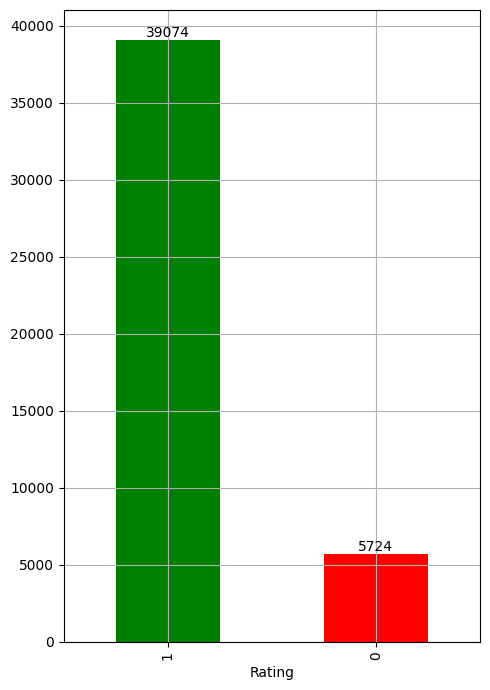

In [8]:
plt.figure(figsize=(5, 7))
countplot = y.value_counts().plot(kind='bar', color=['green', 'red'])
plt.bar_label(countplot.containers[0], label_type='edge')
plt.grid()
plt.tight_layout()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True, 
                                                    stratify=y,
                                                    test_size=0.25, 
                                                    random_state=0)

In [10]:
X_train.isna().sum()

Cleaned_Review    0
Review_Title      0
dtype: int64

In [11]:
# Combine 'Cleaned_Review' and 'Review_Title' into a single text column
X_train = X_train['Review_Title'] + " " + X_train['Cleaned_Review']
X_test = X_test['Review_Title'] + " " + X_test['Review_Title']

In [12]:
X_train.head(2)

6973    Value for money\r\n best bluetooth earphone ru...
4087                                     Really Nice good
dtype: object

In [13]:
# Convert the reviews (text data) into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [14]:
X_train.shape, X_test_tfidf.shape

((33598,), (11200, 5000))

In [15]:
test_X = test_data['Review_Title'] + " " + test_data['Cleaned_Review']
test_data_tfidf = vectorizer.transform(test_X)

In [16]:
test_data.shape, test_data_tfidf.shape

((14932, 3), (14932, 5000))

In [17]:
stratified_k_fold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### XGBoost

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [3, 5, 7, 10],             # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.3, 0.5], # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],           # Fraction of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],    # Fraction of features per tree
    'gamma': [0, 1, 5],                     # Minimum loss reduction
    'reg_alpha': [0, 0.1, 1],               # L1 regularisation
    'reg_lambda': [1, 2, 5],                # L2 regularisation
}

# RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=20,                         # Number of parameter settings to try
    scoring='f1',                      # Use F1 score for binary classification
    cv=stratified_k_fold_cv,           # Stratified K-Fold
    random_state=0,
    n_jobs=-1                          # Use all available processors
)

# Fit the model
xgb_random_search.fit(X_train_tfidf, y_train)
best_xgboost_model = xgb_random_search.best_estimator_

In [ ]:
# Best parameters and score
print("Best Parameters:", xgb_random_search.best_params_)
print("Best F1 Score:", xgb_random_search.best_score_)

# Evaluate on test data
y_pred_xgb = best_xgboost_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_xgb))
print(f'Confusion Matrix:\n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot())
print("F1 Score:", f1_score(y_test, y_pred_xgb))

### Random Forest Classifier

In [18]:
param_grid = {
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_depth': range(1, 12),
    'max_features': ['sqrt', 'log2', None, 8, 10, 12, 13, 14],
    'n_estimators': range(100, 1000, 100),
    'min_samples_split': [2, 5, 10, 15], 
    'min_samples_leaf': [1, 2, 5, 10]
}

random_forest_classifier = RandomForestClassifier()

rfc_model = RandomizedSearchCV(estimator=random_forest_classifier, 
                                      param_distributions=param_grid,
                                      n_iter=20, 
                                      cv=stratified_k_fold_cv, 
                                      scoring='accuracy', 
                                      n_jobs=-1,
                                      random_state=0)

rfc_model.fit(X_train_tfidf, y_train)

best_rfc_model = rfc_model.best_estimator_

# Make predictions on the test data
y_pred = best_rfc_model.predict(X_test_tfidf)

Accuracy: 0.8896205357142857
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.16      0.28      1168
           1       0.89      1.00      0.94      7792

    accuracy                           0.89      8960
   macro avg       0.91      0.58      0.61      8960
weighted avg       0.90      0.89      0.85      8960

Confusion Matrix:
[[ 191  977]
 [  12 7780]]
F1 Score: 0.9402380808508067


Best Parameters: {'n_estimators': 600, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 3, 'criterion': 'entropy'}
Best F1 Score: 0.9260561100355797
Accuracy: 0.9650669642857143
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.95      0.89      0.92      8960
weighted avg       0.96      0.97      0.96      8960

Confusion Matrix:
F1 Score: 0.9801534461987191


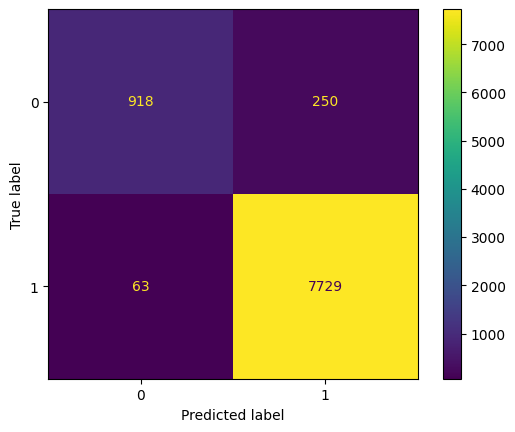

In [38]:
# Best parameters and score
print("Best Parameters:", model.best_params_)
print("Best F1 Score:", model.best_score_)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
print(f'Confusion Matrix:\n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot())
print("F1 Score:", f1_score(y_test, y_pred))

### Support Vector Classifier

In [19]:
# Define the SVC model
svc_model = SVC()

# Parameter grid for SVC
param_grid_svc = {
    'C': [100, 300, 500, 1000],        # Regularisation parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'degree': [2, 3, 4],               # Degree for polynomial kernel
    'gamma': ['scale', 'auto'],        # Kernel coefficient
    'class_weight': [None, 'balanced'] # Handle class imbalance
}

# RandomizedSearchCV for SVC
svc_random_search = RandomizedSearchCV(
    estimator=svc_model,
    param_distributions=param_grid_svc,
    n_iter=20,                         # Number of parameter settings to try
    scoring='f1',                      # Use F1 score for binary classification
    cv=stratified_k_fold_cv,           # Stratified K-Fold
    random_state=0,
    n_jobs=-1                          # Use all available processors
)

# Fit the model
svc_random_search.fit(X_train_tfidf, y_train)
best_svc_model = svc_random_search.best_estimator_

Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'class_weight': None, 'C': 500}
Best F1 Score: 0.9890082245079469
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.95      0.90      0.92      8960
weighted avg       0.97      0.97      0.97      8960

F1 Score: 0.9815108964991422


Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'class_weight': None, 'C': 500}
Best F1 Score: 0.9890082245079469
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.95      0.90      0.92      8960
weighted avg       0.97      0.97      0.97      8960

Confusion Matrix <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000001F9FF2D2A90>
F1 Score: 0.9815108964991422


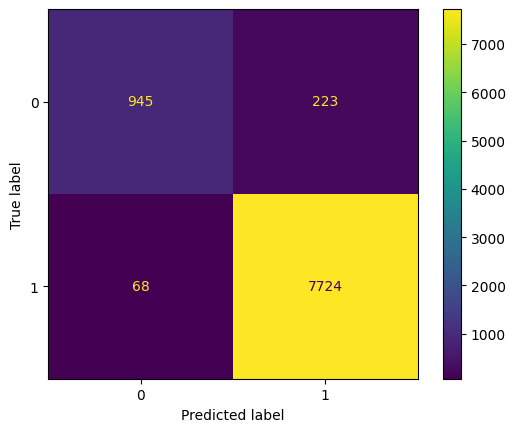

In [40]:
# Best parameters and score
print("Best Parameters:", svc_random_search.best_params_)
print("Best F1 Score:", svc_random_search.best_score_)

y_pred_svc = best_svc_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svc))
print("Confusion Matrix", ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svc)).plot())
print("F1 Score:", f1_score(y_test, y_pred_svc))

### AdaBoost

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    learning_rate = trial.suggest_categorical('learning_rate', [0.5, 1.0, 1.1, 1.2, 1.5, 2.0, 3.0])
    algorithm = trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])

    # Create the model
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm
    )

    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=stratified_k_fold_cv, scoring='f1')
    return scores.mean()

# Run the optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train and evaluate the best model
best_params = study.best_params
best_adaboost_model = AdaBoostClassifier(**best_params)
best_adaboost_model.fit(X_train_tfidf, y_train)

In [20]:
# Define the AdaBoost model
adaboost_model = AdaBoostClassifier()

# Parameter grid for AdaBoost
param_grid_adaboost = {
    'n_estimators': range(100, 1000, 100),   # Number of estimators
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate
    'algorithm': ['SAMME', 'SAMME.R']        # Algorithm variants
}

# RandomizedSearchCV for AdaBoost
adaboost_random_search = RandomizedSearchCV(
    estimator=adaboost_model,
    param_distributions=param_grid_adaboost,
    n_iter=20,                         # Number of parameter settings to try
    scoring='f1',                      # Use F1 score for binary classification
    cv=stratified_k_fold_cv,           # Stratified K-Fold
    random_state=0,
    n_jobs=-1                          # Use all available processors
)

# Fit the model
adaboost_random_search.fit(X_train_tfidf, y_train)
best_adaboost_model = adaboost_random_search.best_estimator_

Best Parameters: {'n_estimators': 300, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
Best F1 Score: 0.9869276956496001
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.95      0.89      0.92      8960
weighted avg       0.96      0.97      0.96      8960

F1 Score: 0.9801534461987191


Best Parameters: {'n_estimators': 300, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
Best F1 Score: 0.9869276956496001
              precision    recall  f1-score   support

           0       0.94      0.79      0.85      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.95      0.89      0.92      8960
weighted avg       0.96      0.97      0.96      8960

Confusion Matrix <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000001F9FCEE2BD0>
F1 Score: 0.9801534461987191


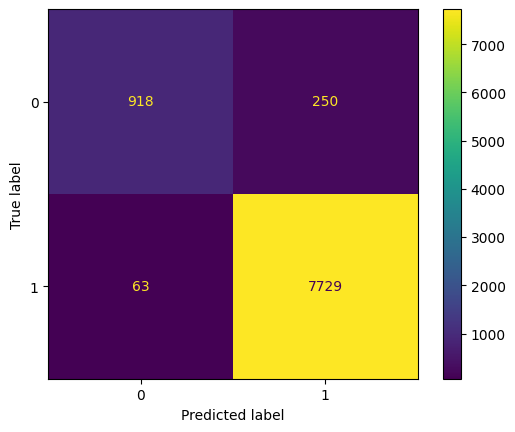

In [37]:
# Best parameters and score
print("Best Parameters:", adaboost_random_search.best_params_)
print("Best F1 Score:", adaboost_random_search.best_score_)

y_pred_adaboost = best_adaboost_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_adaboost))
print("Confusion Matrix", ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_adaboost)).plot())
print("F1 Score:", f1_score(y_test, y_pred_adaboost))

### Voting Classifier

In [21]:
# Define the best Random Forest and SVC models
best_rf = model.best_estimator_  # Best Random Forest from RandomizedSearchCV
best_svc = svc_random_search.best_estimator_  # Best SVC from RandomizedSearchCV

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('random_forest', best_rf),
        ('svc', best_svc),
        ('ada_boost', best_adaboost_model),
        ('xgboost', best_xgboost_model)
    ],
    voting='hard'
)

# Fit the ensemble model
voting_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test_tfidf)

Classification Report for Ensemble:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1168
           1       0.97      0.99      0.98      7792

    accuracy                           0.97      8960
   macro avg       0.96      0.89      0.92      8960
weighted avg       0.97      0.97      0.96      8960

F1 Score: 0.9806353626123275


In [ ]:
# Evaluate the ensemble model
print("Classification Report for Ensemble:")
print(classification_report(y_test, y_pred_voting))
print("Confusion matrix", ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting)).plot())
print("F1 Score:", f1_score(y_test, y_pred_voting))

### Stacking Classifier

In [41]:
stacking_clf = StackingClassifier(
    estimators = [
        ('random_forest', best_rf),
        ('svc', best_svc), 
        ('ada_boost', best_adaboost_model),
        ('xgboost', best_xgboost_model)
    ],
    final_estimator=RandomForestClassifier()  # Meta-classifier
)

stacking_clf.fit(X_train_tfidf, y_train)
y_pred_stacking = stacking_clf.predict(X_test_tfidf)

Classification Report for Stacking Ensemble:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1168
           1       0.98      0.98      0.98      7792

    accuracy                           0.96      8960
   macro avg       0.91      0.91      0.91      8960
weighted avg       0.96      0.96      0.96      8960

Confusion Matrix <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000001F9FF1B0990>
F1 Score: 0.9761858912638809


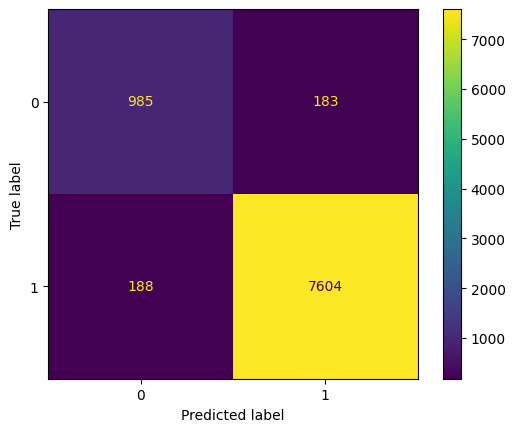

In [42]:
print("Classification Report for Stacking Ensemble:")
print(classification_report(y_test, y_pred_stacking))
print("Confusion Matrix", ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking)).plot())
print("F1 Score:", f1_score(y_test, y_pred_stacking))

In [23]:
test_pred = voting_clf.predict(test_data_tfidf)

In [24]:
len(test_pred)

14932

In [43]:
# Get probabilities and compute thresholds
y_probs = stacking_clf.predict_proba(X_test_tfidf)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Choose threshold based on F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

# Predict with the best threshold
y_pred_custom = (y_probs >= best_threshold).astype(int)
print("F1 Score with Custom Threshold:", f1_scores.max())

F1 Score with Custom Threshold: 0.9807996958367657


In [44]:
test_probs = stacking_clf.predict_proba(test_data_tfidf)[:, 1]
test_pred_custom = (test_probs >= best_threshold).astype(int)

In [27]:
submission_df = pd.DataFrame({
    'ID': test_data['ID'],
    'Rating': test_pred_custom
})

,ID,Rating
0,0,1
1,1,1


,ID,Rating
14930,16373,1
14931,16374,1


In [ ]:
display(submission_df.head(2))
display(dsubmission_dff.tail(2))

In [28]:
submission_df.to_csv('NLP_Hackathon_JN_.csv', index=False)